In [1]:
import collections
import itertools
import os
import pickle

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import transformers

from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
def textbf(text):
    return '\033[1m' + text + '\033[0m'

def textcolor(text, color):
    code = {'red': '31', 'green': '32', 'yellow': '33', 'blue': '34', 'magenta': '35', 'cyan': '36', 'white': '37'}
    return '\033[' + code[color] + 'm' + text + '\033[0m'

In [3]:
data_dir = '../data/N2C2-Track3-May3/'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'), low_memory=False)
print(f'Train {len(df_train)} rows')
df_dev = pd.read_csv(os.path.join(data_dir, 'dev.csv'), low_memory=False)
print(f'Dev {len(df_dev)} rows')

Train 4633 rows
Dev 597 rows


In [4]:
_relation_labels = {'Direct': 0, 'Indirect': 1, 'Neither': 2, 'Not Relevant': 3}
relations, labels = list(zip(*_relation_labels.items()))
relation_to_label = _relation_labels
label_to_relation = {v: k for k, v in relation_to_label.items()}
num_labels = len(relation_to_label)

In [5]:
train_labels = np.array([relation_to_label[r] for r in df_train['Relation']])
dev_labels = np.array([relation_to_label[r] for r in df_dev['Relation']])

## Accuracy / conf matrix

In [6]:
def confusion_matrix_strs(y_true, y_pred, dataset=''):
    conf_mat = sklearn.metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
    results = []
    results.append(f'{dataset.upper():<9}' + ' '.join([f'{r[:8]:>8}' for r in relations]) + '  Lbl cnt')
    for i in range(4):
        results.append(f'{relations[i][:8]:>8} ' + ' '.join([f'{c:8}' for c in conf_mat[i]]) + f' {sum(conf_mat[i]):8}')    
    results.append(f'Pred cnt ' + ' '.join([f'{sum(conf_mat[:,i]):8}' for i in range(4)]) + f' {np.sum(conf_mat):8}')    
    return results

def plot_confusion_matrix_traindev(train_preds, dev_preds):
    plt.figure(figsize=(12, 4))
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay.from_predictions(y_true=train_labels, y_pred=train_preds, normalize='true', cmap=plt.cm.Blues, ax=ax)
    plt.title('Train prediction'); plt.xticks(*zip(*label_to_relation.items())); plt.yticks(*zip(*label_to_relation.items()))
    ax = plt.subplot(1, 2, 2)
    ConfusionMatrixDisplay.from_predictions(y_true=dev_labels, y_pred=dev_preds, normalize='true', cmap=plt.cm.Blues, ax=ax)
    plt.title('Dev prediction'); plt.xticks(*zip(*label_to_relation.items())); plt.yticks(*zip(*label_to_relation.items()))

    train_correct = train_labels == train_preds
    dev_correct = dev_labels == dev_preds
    print(f'- Train set performance')
    print(f'    - Accuracy: {np.mean(train_correct):.6f} ({sum(train_correct)}/{len(train_correct)})')
    print(f'    - Macro F1: {sklearn.metrics.f1_score(y_true=train_labels, y_pred=train_preds, average="macro"):.6f}')
    print(f'- Dev set performance')
    print(f'    - Accuracy: {np.mean(dev_correct):.6f} ({sum(dev_correct)}/{len(dev_correct)})')
    print(f'    - Macro F1: {sklearn.metrics.f1_score(y_true=dev_labels, y_pred=dev_preds, average="macro"):.6f}')
    
    train_conf_strs = confusion_matrix_strs(train_labels, train_preds, 'train')
    dev_conf_strs = confusion_matrix_strs(dev_labels, dev_preds, 'dev')
    for str1, str2 in zip(train_conf_strs, dev_conf_strs):
        print(str1 + ' | ' + str2)

def plot_results(results_dir, ckpt_step=9999):
    print(f'[Experiment {results_dir}, step {ckpt_step}]')
    with open(os.path.join(results_dir, f'results_train_{ckpt_step}.pkl'), 'rb') as fd:
        train_results = pickle.load(fd)
    with open(os.path.join(results_dir, f'results_dev_{ckpt_step}.pkl'), 'rb') as fd:
        dev_results = pickle.load(fd)
    train_preds = np.argmax(np.array([r['logits'] for r in train_results]), axis=1)
    dev_preds = np.argmax(np.array([r['logits'] for r in dev_results]), axis=1)
    plot_confusion_matrix_traindev(train_preds, dev_preds)

def softmax(logits):
    logits = np.array(logits)
    logits -= (np.max(logits, axis=1, keepdims=True) - np.min(logits, axis=1, keepdims=True)) / 2
    exps = np.exp(logits)
    return exps / np.sum(exps, axis=1, keepdims=True)
    
def plot_results_ensemble(dir_step_list, ensemble="logits"):
    print('Ensemble of following results')
    train_logitss, dev_logitss = [], []
    for results_dir, ckpt_step in dir_step_list:
        print(f'\t({results_dir}, step {ckpt_step})')
        with open(os.path.join(results_dir, f'results_train_{ckpt_step}.pkl'), 'rb') as fd:
            train_results_temp = pickle.load(fd)
        with open(os.path.join(results_dir, f'results_dev_{ckpt_step}.pkl'), 'rb') as fd:
            dev_results_temp = pickle.load(fd)
        train_logitss.append(np.array([r['logits'] for r in train_results_temp]))
        dev_logitss.append(np.array([r['logits'] for r in dev_results_temp]))
    
    if ensemble == "logits":
        train_values = np.array(train_logitss).sum(axis=0)
        dev_values = np.array(dev_logitss).sum(axis=0)
    elif ensemble == "probs":
        train_values = np.array([softmax(logits) for logits in train_logitss]).sum(axis=0)
        dev_values = np.array([softmax(logits) for logits in dev_logitss]).sum(axis=0)
    else:
        raise ValueError(f"Wrong emsenble value: {ensemble}")
        
    train_preds = np.argmax(train_values, axis=1)
    dev_preds = np.argmax(dev_values, axis=1)
    plot_confusion_matrix_traindev(train_preds, dev_preds)       

## Ensemble Results

1. Best Sentence Relation Models (Clinical BERTs)

Ensemble of following results
	(../results/sent_rel_PubMedBERT/, step 9000)
	(../results/sent_rel_BioClinicalBERT/, step 7000)
	(../results/sent_rel_BlueBERT-Base/, step 6000)
	(../results/sent_rel_BlueBERT-Large/, step 7000)
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.797320 (476/597)
    - Macro F1: 0.816609
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      113       24        7        1      145
Indirect        0     1249        0        0     1249 | Indirect       10      130       38        1      179
 Neither        0        0     1484        0     1484 |  Neither        1       30      142        0      173
Not Rele        0        0        0      810      810 | Not Rele        3        2        4       91      100
Pred cnt     1090     1249     1484      810     4633 | 

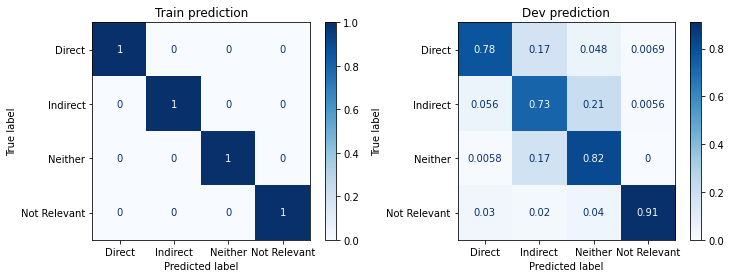

In [7]:
dir_step_list_best = [
#     ('../results/sent_rel_bert-base-uncased/', 8000),
    ('../results/sent_rel_PubMedBERT/', 9000),
    ('../results/sent_rel_BioClinicalBERT/', 7000),
    ('../results/sent_rel_BlueBERT-Base/', 6000),
    ('../results/sent_rel_BlueBERT-Large/', 7000),
#     ('../results/sent_sim_bert-base-uncased/', 7000),
#     ('../results/sent_sim2_bert-base-uncased/', 9999),
#     ('../results/sent_sim_PubMedBERT/', 9999),
#     ('../results/sent_sim2_PubMedBERT/', 8000),
]
plot_results_ensemble(dir_step_list_best)

Ensemble of following results
	(../results/sent_rel_PubMedBERT/, step 9000)
	(../results/sent_rel_BioClinicalBERT/, step 7000)
	(../results/sent_rel_BlueBERT-Base/, step 6000)
	(../results/sent_rel_BlueBERT-Large/, step 7000)
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.797320 (476/597)
    - Macro F1: 0.814435
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      114       22        7        2      145
Indirect        0     1249        0        0     1249 | Indirect       10      129       37        3      179
 Neither        0        0     1484        0     1484 |  Neither        1       30      142        0      173
Not Rele        0        0        0      810      810 | Not Rele        4        1        4       91      100
Pred cnt     1090     1249     1484      810     4633 | 

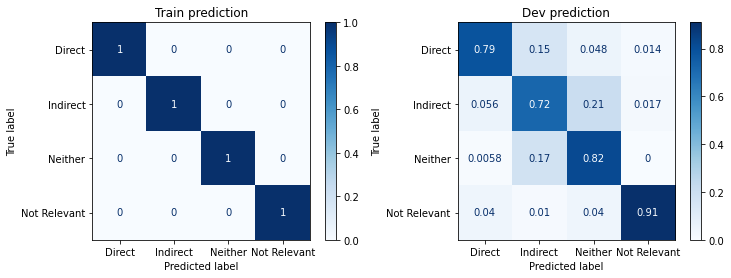

In [8]:
plot_results_ensemble(dir_step_list_best, ensemble="probs")

2. Last Sentence Relation Models (Clinical BERTs)

Ensemble of following results
	(../results/sent_rel_PubMedBERT/, step 9999)
	(../results/sent_rel_BioClinicalBERT/, step 9999)
	(../results/sent_rel_BlueBERT-Base/, step 9999)
	(../results/sent_rel_BlueBERT-Large/, step 9999)
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.797320 (476/597)
    - Macro F1: 0.816668
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      111       27        6        1      145
Indirect        0     1249        0        0     1249 | Indirect        9      133       36        1      179
 Neither        0        0     1484        0     1484 |  Neither        2       30      141        0      173
Not Rele        0        0        0      810      810 | Not Rele        2        3        4       91      100
Pred cnt     1090     1249     1484      810     4633 | 

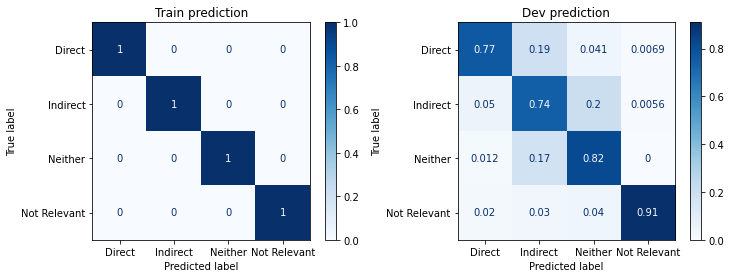

In [9]:
dir_step_list_best = [
#     ('../results/sent_rel_bert-base-uncased/', 9999),
    ('../results/sent_rel_PubMedBERT/', 9999),
    ('../results/sent_rel_BioClinicalBERT/', 9999),
    ('../results/sent_rel_BlueBERT-Base/', 9999),
    ('../results/sent_rel_BlueBERT-Large/', 9999),
#     ('../results/sent_sim_bert-base-uncased/', 9999),
#     ('../results/sent_sim2_bert-base-uncased/', 9999),
#     ('../results/sent_sim_PubMedBERT/', 9999),
#     ('../results/sent_sim2_PubMedBERT/', 9999),
]
plot_results_ensemble(dir_step_list_best)

Ensemble of following results
	(../results/sent_rel_PubMedBERT/, step 9999)
	(../results/sent_rel_BioClinicalBERT/, step 9999)
	(../results/sent_rel_BlueBERT-Base/, step 9999)
	(../results/sent_rel_BlueBERT-Large/, step 9999)
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.798995 (477/597)
    - Macro F1: 0.817283
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      112       25        6        2      145
Indirect        0     1249        0        0     1249 | Indirect        8      132       37        2      179
 Neither        0        0     1484        0     1484 |  Neither        1       30      142        0      173
Not Rele        0        0        0      810      810 | Not Rele        2        3        4       91      100
Pred cnt     1090     1249     1484      810     4633 | 

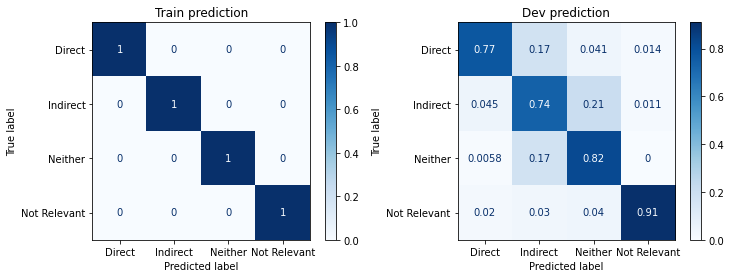

In [10]:
plot_results_ensemble(dir_step_list_best, ensemble="probs")

3. Best Sentence Relation Models (All)

Ensemble of following results
	(../results/sent_rel_bert-base-uncased/, step 8000)
	(../results/sent_rel_PubMedBERT/, step 9000)
	(../results/sent_rel_BioClinicalBERT/, step 7000)
	(../results/sent_rel_BlueBERT-Base/, step 6000)
	(../results/sent_rel_BlueBERT-Large/, step 7000)
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.797320 (476/597)
    - Macro F1: 0.815177
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      114       21        9        1      145
Indirect        0     1249        0        0     1249 | Indirect        9      132       36        2      179
 Neither        0        0     1484        0     1484 |  Neither        1       31      140        1      173
Not Rele        0        0        0      810      810 | Not Rele        3        2        5       90      100
Pre

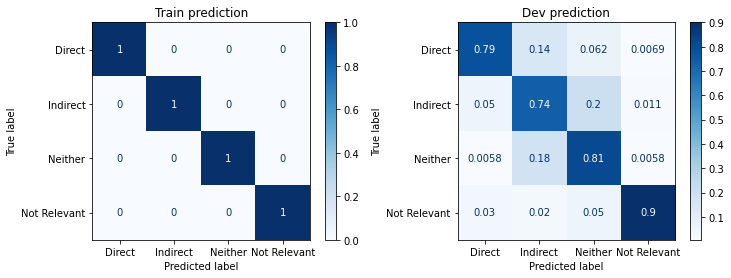

In [11]:
dir_step_list_best = [
    ('../results/sent_rel_bert-base-uncased/', 8000),
    ('../results/sent_rel_PubMedBERT/', 9000),
    ('../results/sent_rel_BioClinicalBERT/', 7000),
    ('../results/sent_rel_BlueBERT-Base/', 6000),
    ('../results/sent_rel_BlueBERT-Large/', 7000),
#     ('../results/sent_sim_bert-base-uncased/', 7000),
#     ('../results/sent_sim2_bert-base-uncased/', 9999),
#     ('../results/sent_sim_PubMedBERT/', 9999),
#     ('../results/sent_sim2_PubMedBERT/', 8000),
]
plot_results_ensemble(dir_step_list_best)

Ensemble of following results
	(../results/sent_rel_bert-base-uncased/, step 8000)
	(../results/sent_rel_PubMedBERT/, step 9000)
	(../results/sent_rel_BioClinicalBERT/, step 7000)
	(../results/sent_rel_BlueBERT-Base/, step 6000)
	(../results/sent_rel_BlueBERT-Large/, step 7000)
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.797320 (476/597)
    - Macro F1: 0.814707
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      114       21        8        2      145
Indirect        0     1249        0        0     1249 | Indirect       10      130       36        3      179
 Neither        0        0     1484        0     1484 |  Neither        1       31      141        0      173
Not Rele        0        0        0      810      810 | Not Rele        3        1        5       91      100
Pre

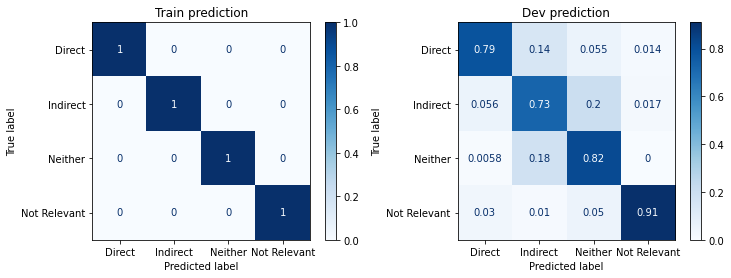

In [12]:
plot_results_ensemble(dir_step_list_best, ensemble="probs")

4. Best Sentence Similarity Models (All)

Ensemble of following results
	(../results/sent_sim_bert-base-uncased/, step 7000)
	(../results/sent_sim2_bert-base-uncased/, step 9999)
	(../results/sent_sim_PubMedBERT/, step 9999)
	(../results/sent_sim2_PubMedBERT/, step 8000)
- Train set performance
    - Accuracy: 0.999784 (4632/4633)
    - Macro F1: 0.999785
- Dev set performance
    - Accuracy: 0.696817 (416/597)
    - Macro F1: 0.724579
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      105       28       12        0      145
Indirect        1     1248        0        0     1249 | Indirect       14      118       44        3      179
 Neither        0        0     1484        0     1484 |  Neither        8       57      106        2      173
Not Rele        0        0        0      810      810 | Not Rele        8        3        2       87      100
Pred cnt     1091     1248     1484      810     463

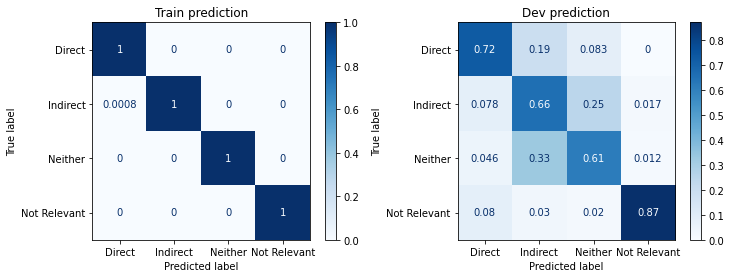

In [13]:
dir_step_list_best = [
#     ('../results/sent_rel_bert-base-uncased/', 8000),
#     ('../results/sent_rel_PubMedBERT/', 9000),
#     ('../results/sent_rel_BioClinicalBERT/', 7000),
#     ('../results/sent_rel_BlueBERT-Base/', 6000),
#     ('../results/sent_rel_BlueBERT-Large/', 7000),
    ('../results/sent_sim_bert-base-uncased/', 7000),
    ('../results/sent_sim2_bert-base-uncased/', 9999),
    ('../results/sent_sim_PubMedBERT/', 9999),
    ('../results/sent_sim2_PubMedBERT/', 8000),
]
plot_results_ensemble(dir_step_list_best)

Ensemble of following results
	(../results/sent_sim_bert-base-uncased/, step 7000)
	(../results/sent_sim2_bert-base-uncased/, step 9999)
	(../results/sent_sim_PubMedBERT/, step 9999)
	(../results/sent_sim2_PubMedBERT/, step 8000)
- Train set performance
    - Accuracy: 0.999784 (4632/4633)
    - Macro F1: 0.999785
- Dev set performance
    - Accuracy: 0.691792 (413/597)
    - Macro F1: 0.719493
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      100       30       15        0      145
Indirect        1     1248        0        0     1249 | Indirect       14      118       45        2      179
 Neither        0        0     1484        0     1484 |  Neither        9       53      109        2      173
Not Rele        0        0        0      810      810 | Not Rele        8        3        3       86      100
Pred cnt     1091     1248     1484      810     463

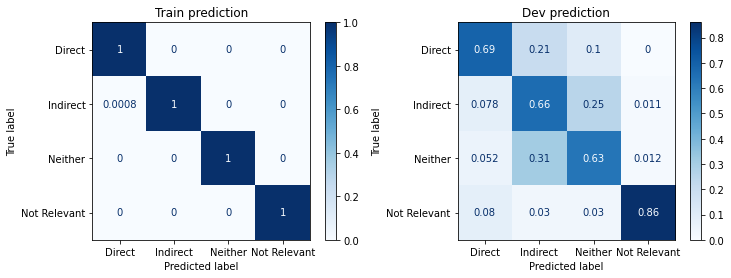

In [14]:
plot_results_ensemble(dir_step_list_best, ensemble="probs")

5. Best Models (Clinical BERTs)

Ensemble of following results
	(../results/sent_rel_PubMedBERT/, step 9000)
	(../results/sent_rel_BioClinicalBERT/, step 7000)
	(../results/sent_rel_BlueBERT-Base/, step 6000)
	(../results/sent_rel_BlueBERT-Large/, step 7000)
	(../results/sent_sim_PubMedBERT/, step 9999)
	(../results/sent_sim2_PubMedBERT/, step 8000)
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.785595 (469/597)
    - Macro F1: 0.806542
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      114       24        7        0      145
Indirect        0     1249        0        0     1249 | Indirect        9      128       40        2      179
 Neither        0        0     1484        0     1484 |  Neither        3       33      137        0      173
Not Rele        0        0        0      810      810 | Not Rele        3

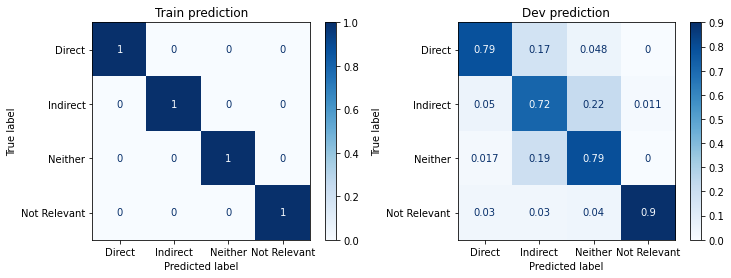

In [15]:
dir_step_list_best = [
#     ('../results/sent_rel_bert-base-uncased/', 8000),
    ('../results/sent_rel_PubMedBERT/', 9000),
    ('../results/sent_rel_BioClinicalBERT/', 7000),
    ('../results/sent_rel_BlueBERT-Base/', 6000),
    ('../results/sent_rel_BlueBERT-Large/', 7000),
#     ('../results/sent_sim_bert-base-uncased/', 7000),
#     ('../results/sent_sim2_bert-base-uncased/', 9999),
    ('../results/sent_sim_PubMedBERT/', 9999),
    ('../results/sent_sim2_PubMedBERT/', 8000),
]
plot_results_ensemble(dir_step_list_best)

Ensemble of following results
	(../results/sent_rel_PubMedBERT/, step 9000)
	(../results/sent_rel_BioClinicalBERT/, step 7000)
	(../results/sent_rel_BlueBERT-Base/, step 6000)
	(../results/sent_rel_BlueBERT-Large/, step 7000)
	(../results/sent_sim_PubMedBERT/, step 9999)
	(../results/sent_sim2_PubMedBERT/, step 8000)
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.792295 (473/597)
    - Macro F1: 0.811518
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      113       24        7        1      145
Indirect        0     1249        0        0     1249 | Indirect       11      128       38        2      179
 Neither        0        0     1484        0     1484 |  Neither        2       31      140        0      173
Not Rele        0        0        0      810      810 | Not Rele        4

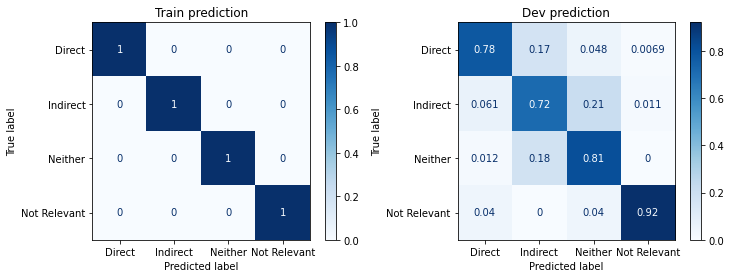

In [16]:
plot_results_ensemble(dir_step_list_best, ensemble="probs")

6. Best Models (All)

Ensemble of following results
	(../results/sent_rel_bert-base-uncased/, step 8000)
	(../results/sent_rel_PubMedBERT/, step 9000)
	(../results/sent_rel_BioClinicalBERT/, step 7000)
	(../results/sent_rel_BlueBERT-Base/, step 6000)
	(../results/sent_rel_BlueBERT-Large/, step 7000)
	(../results/sent_sim_bert-base-uncased/, step 7000)
	(../results/sent_sim2_bert-base-uncased/, step 9999)
	(../results/sent_sim_PubMedBERT/, step 9999)
	(../results/sent_sim2_PubMedBERT/, step 8000)
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.778894 (465/597)
    - Macro F1: 0.799589
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      113       25        6        1      145
Indirect        0     1249        0        0     1249 | Indirect       11      131       36        1      179
 Neither        0      

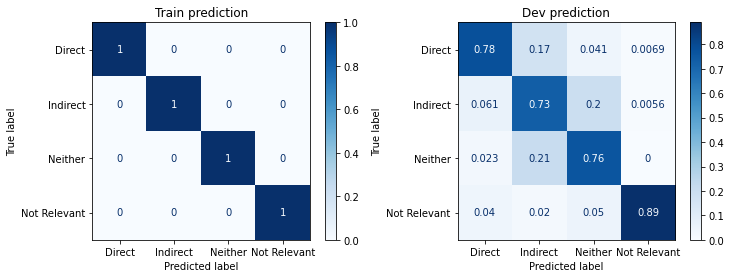

In [17]:
dir_step_list_best = [
    ('../results/sent_rel_bert-base-uncased/', 8000),
    ('../results/sent_rel_PubMedBERT/', 9000),
    ('../results/sent_rel_BioClinicalBERT/', 7000),
    ('../results/sent_rel_BlueBERT-Base/', 6000),
    ('../results/sent_rel_BlueBERT-Large/', 7000),
    ('../results/sent_sim_bert-base-uncased/', 7000),
    ('../results/sent_sim2_bert-base-uncased/', 9999),
    ('../results/sent_sim_PubMedBERT/', 9999),
    ('../results/sent_sim2_PubMedBERT/', 8000),
]
plot_results_ensemble(dir_step_list_best)

Ensemble of following results
	(../results/sent_rel_bert-base-uncased/, step 8000)
	(../results/sent_rel_PubMedBERT/, step 9000)
	(../results/sent_rel_BioClinicalBERT/, step 7000)
	(../results/sent_rel_BlueBERT-Base/, step 6000)
	(../results/sent_rel_BlueBERT-Large/, step 7000)
	(../results/sent_sim_bert-base-uncased/, step 7000)
	(../results/sent_sim2_bert-base-uncased/, step 9999)
	(../results/sent_sim_PubMedBERT/, step 9999)
	(../results/sent_sim2_PubMedBERT/, step 8000)
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.792295 (473/597)
    - Macro F1: 0.812074
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      113       24        8        0      145
Indirect        0     1249        0        0     1249 | Indirect       10      137       31        1      179
 Neither        0      

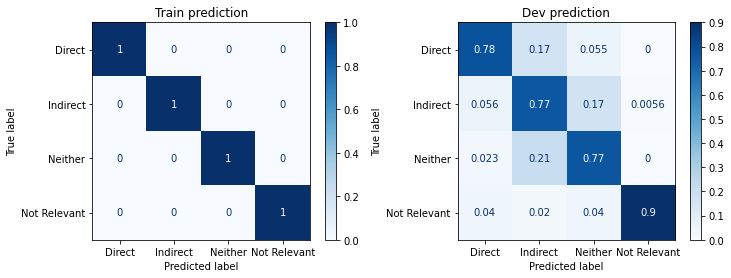

In [18]:
plot_results_ensemble(dir_step_list_best, ensemble="probs")

7. Last Models (All)

Ensemble of following results
	(../results/sent_rel_bert-base-uncased/, step 9999)
	(../results/sent_rel_PubMedBERT/, step 9999)
	(../results/sent_rel_BioClinicalBERT/, step 9999)
	(../results/sent_rel_BlueBERT-Base/, step 9999)
	(../results/sent_rel_BlueBERT-Large/, step 9999)
	(../results/sent_sim_bert-base-uncased/, step 9999)
	(../results/sent_sim2_bert-base-uncased/, step 9999)
	(../results/sent_sim_PubMedBERT/, step 9999)
	(../results/sent_sim2_PubMedBERT/, step 9999)
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.780570 (466/597)
    - Macro F1: 0.801868
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      110       28        6        1      145
Indirect        0     1249        0        0     1249 | Indirect       10      133       35        1      179
 Neither        0      

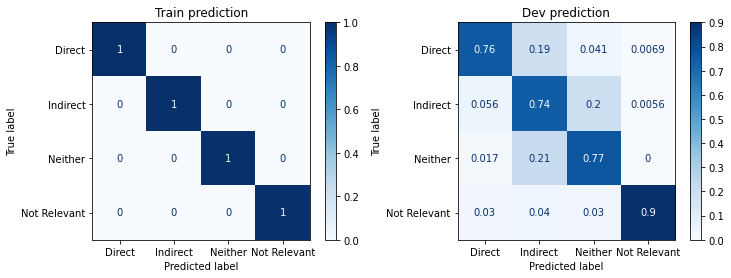

In [19]:
dir_step_list_best = [
    ('../results/sent_rel_bert-base-uncased/', 9999),
    ('../results/sent_rel_PubMedBERT/', 9999),
    ('../results/sent_rel_BioClinicalBERT/', 9999),
    ('../results/sent_rel_BlueBERT-Base/', 9999),
    ('../results/sent_rel_BlueBERT-Large/', 9999),
    ('../results/sent_sim_bert-base-uncased/', 9999),
    ('../results/sent_sim2_bert-base-uncased/', 9999),
    ('../results/sent_sim_PubMedBERT/', 9999),
    ('../results/sent_sim2_PubMedBERT/', 9999),
]
plot_results_ensemble(dir_step_list_best)

Ensemble of following results
	(../results/sent_rel_bert-base-uncased/, step 9999)
	(../results/sent_rel_PubMedBERT/, step 9999)
	(../results/sent_rel_BioClinicalBERT/, step 9999)
	(../results/sent_rel_BlueBERT-Base/, step 9999)
	(../results/sent_rel_BlueBERT-Large/, step 9999)
	(../results/sent_sim_bert-base-uncased/, step 9999)
	(../results/sent_sim2_bert-base-uncased/, step 9999)
	(../results/sent_sim_PubMedBERT/, step 9999)
	(../results/sent_sim2_PubMedBERT/, step 9999)
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.790620 (472/597)
    - Macro F1: 0.811423
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      114       23        8        0      145
Indirect        0     1249        0        0     1249 | Indirect        8      134       37        0      179
 Neither        0      

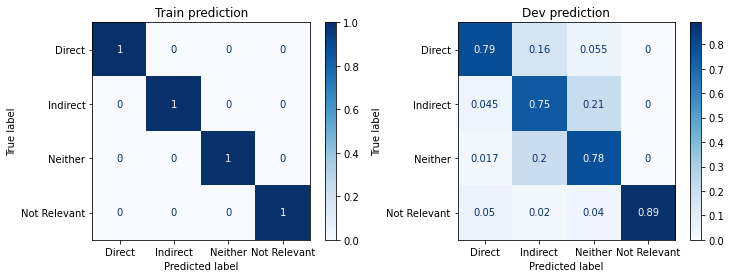

In [20]:
plot_results_ensemble(dir_step_list_best, ensemble="probs")

## Find the best combination

In [21]:
exp_step_dict = {
    "sent_rel_bert-base-uncased": {"best": 8000, "last": 9999},
    "sent_rel_PubMedBERT": {"best": 9000, "last": 9999},
    "sent_rel_BioClinicalBERT": {"best": 7000, "last": 9999},
    "sent_rel_BlueBERT-Base": {"best": 6000, "last": 9999},
    "sent_rel_BlueBERT-Large": {"best": 7000, "last": 9999},
    "sent_sim_bert-base-uncased": {"best": 7000, "last": 9999},
    "sent_sim2_bert-base-uncased": {"best": 9999, "last": 9999},
    "sent_sim_PubMedBERT": {"best": 9999, "last": 9999},
    "sent_sim2_PubMedBERT": {"best": 8000, "last": 9999},
}

In [22]:
def load_train_dev_logits(exp_name, ckpt_step):
    results_dir = f'../results/{exp_name}/'
    with open(os.path.join(results_dir, f'results_train_{ckpt_step}.pkl'), 'rb') as fd:
        train_results_temp = pickle.load(fd)
    with open(os.path.join(results_dir, f'results_dev_{ckpt_step}.pkl'), 'rb') as fd:
        dev_results_temp = pickle.load(fd)
    train_logits = np.array([r['logits'] for r in train_results_temp])
    dev_logits = np.array([r['logits'] for r in dev_results_temp])
    return train_logits, dev_logits

exp_dev_logits_dict = {}
zero_dev_logits = np.zeros((len(df_dev), 4), dtype=np.float32)
for exp_name, step_dict in exp_step_dict.items():
    best_step, last_step = exp_step_dict[exp_name]['best'], exp_step_dict[exp_name]['last']
    exp_dev_logits_dict[exp_name] = [zero_dev_logits]
    exp_dev_logits_dict[exp_name].append(load_train_dev_logits(exp_name, best_step)[1])
    if last_step != best_step:
        exp_dev_logits_dict[exp_name].append(load_train_dev_logits(exp_name, last_step)[1])

In [23]:
for k, v in exp_dev_logits_dict.items():
    print(f'{k}({len(v)}): {[arr.shape for arr in v]}')

sent_rel_bert-base-uncased(3): [(597, 4), (597, 4), (597, 4)]
sent_rel_PubMedBERT(3): [(597, 4), (597, 4), (597, 4)]
sent_rel_BioClinicalBERT(3): [(597, 4), (597, 4), (597, 4)]
sent_rel_BlueBERT-Base(3): [(597, 4), (597, 4), (597, 4)]
sent_rel_BlueBERT-Large(3): [(597, 4), (597, 4), (597, 4)]
sent_sim_bert-base-uncased(3): [(597, 4), (597, 4), (597, 4)]
sent_sim2_bert-base-uncased(2): [(597, 4), (597, 4)]
sent_sim_PubMedBERT(2): [(597, 4), (597, 4)]
sent_sim2_PubMedBERT(3): [(597, 4), (597, 4), (597, 4)]


In [24]:
exp_list = list(exp_dev_logits_dict.keys())
logit_items_list = [len(exp_dev_logits_dict[exp_name]) for exp_name in exp_list]

def ensemble_preds(idx_list, exp_list=exp_list, ensemble="logits"):
    dev_values = np.zeros((len(df_dev), 4), dtype=np.float32)
    for exp_name, idx in zip(exp_list, idx_list):
        dev_logits = exp_dev_logits_dict[exp_name][idx]
        if ensemble == "logits":
            dev_values += dev_logits
        elif ensemble == "probs":
            dev_values += softmax(dev_logits)
    dev_preds = np.argmax(dev_values, axis=1)
    return dev_preds
    
def compute_ensemble_macro_f1(idx_list, exp_list=exp_list, ensemble="logits", ):
    dev_preds = ensemble_preds(idx_list, exp_list, ensemble)
    macro_f1 = sklearn.metrics.f1_score(y_true=dev_labels, y_pred=dev_preds, average="macro")
    return macro_f1

### Which is the better values to ensemble? (probs? logits?)

$\rightarrow$ probs

In [25]:
logits_win, probs_win = 0, 0
for idx_list in itertools.product(*[list(range(items)) for items in logit_items_list]):
    macro_f1_logits = compute_ensemble_macro_f1(idx_list)
    macro_f1_probs = compute_ensemble_macro_f1(idx_list, ensemble='probs')
    logits_win += 1 if macro_f1_logits > macro_f1_probs else 0
    probs_win += 0 if macro_f1_logits > macro_f1_probs else 1
print(f'Logits win: {logits_win} / Probs win: {probs_win}')

Logits win: 3058 / Probs win: 5690


### - Combination from sent rel models

In [26]:
exp_list_sent_rel = ['sent_rel_bert-base-uncased',
                     'sent_rel_PubMedBERT',
                     'sent_rel_BioClinicalBERT',
                     'sent_rel_BlueBERT-Base',
                     'sent_rel_BlueBERT-Large']
logit_items_list_sent_rel = [len(exp_dev_logits_dict[exp_name]) for exp_name in exp_list_sent_rel]
best_idx_list, best_dev_macro_f1 = (), 0.8

for idx_list in itertools.product(*[list(range(items)) for items in logit_items_list_sent_rel]):
    macro_f1 = compute_ensemble_macro_f1(idx_list, exp_list_sent_rel, "probs")
    if macro_f1 > best_dev_macro_f1:
        best_idx_list, best_dev_macro_f1 = idx_list, macro_f1
        print(f'{idx_list}: {macro_f1:.6f}')

(0, 0, 0, 0, 1): 0.805841
(0, 0, 0, 1, 1): 0.813659
(0, 0, 0, 1, 2): 0.815746
(0, 0, 1, 1, 1): 0.817769
(0, 0, 1, 1, 2): 0.821904
(0, 1, 1, 0, 2): 0.824643
(1, 2, 1, 2, 0): 0.827949


### - Combination from sent sim models

In [27]:
exp_list_sent_sim = ['sent_sim_bert-base-uncased',
                     'sent_sim2_bert-base-uncased',
                     'sent_sim_PubMedBERT',
                     'sent_sim2_PubMedBERT']
exp_dev_logits_dict_sent_sim = {exp_name: exp_dev_logits_dict[exp_name] for exp_name in exp_list_sent_sim}
logit_items_list_sent_sim = [len(exp_dev_logits_dict[exp_name]) for exp_name in exp_list_sent_sim]
best_idx_list, best_dev_macro_f1 = (), 0.7

for idx_list in itertools.product(*[list(range(items)) for items in logit_items_list_sent_sim]):
    macro_f1 = compute_ensemble_macro_f1(idx_list, exp_list_sent_sim, "probs")
    if macro_f1 > best_dev_macro_f1:
        best_idx_list, best_dev_macro_f1 = idx_list, macro_f1
        print(f'{idx_list}: {macro_f1:.6f}')

(0, 0, 0, 1): 0.700254
(0, 0, 1, 0): 0.701512
(0, 0, 1, 1): 0.701610
(0, 0, 1, 2): 0.701976
(0, 1, 0, 1): 0.709833
(0, 1, 0, 2): 0.723675
(0, 1, 1, 1): 0.725617
(2, 1, 1, 2): 0.725983


### - Combination from all models

In [28]:
best_idx_list, best_dev_macro_f1 = (), 0.8

for idx_list in itertools.product(*[list(range(items)) for items in logit_items_list]):
    macro_f1 = compute_ensemble_macro_f1(idx_list, ensemble="probs")
    if macro_f1 > best_dev_macro_f1:
        best_idx_list, best_dev_macro_f1 = idx_list, macro_f1
        print(f'{idx_list}: {macro_f1:.6f}')

(0, 0, 0, 0, 1, 0, 0, 0, 0): 0.805841
(0, 0, 0, 1, 1, 0, 0, 0, 0): 0.813659
(0, 0, 0, 1, 2, 0, 0, 0, 0): 0.815746
(0, 0, 1, 0, 1, 0, 1, 0, 0): 0.815860
(0, 0, 1, 0, 1, 1, 0, 0, 0): 0.817320
(0, 0, 1, 0, 2, 0, 1, 0, 0): 0.820355
(0, 0, 1, 1, 1, 0, 0, 0, 2): 0.820622
(0, 0, 1, 1, 1, 0, 1, 0, 0): 0.822941
(0, 0, 1, 1, 2, 0, 1, 0, 0): 0.823295
(0, 0, 2, 1, 1, 1, 0, 0, 0): 0.823297
(0, 1, 1, 0, 1, 1, 0, 0, 0): 0.824151
(0, 1, 1, 0, 2, 0, 0, 0, 0): 0.824643
(0, 1, 1, 1, 0, 1, 0, 0, 0): 0.826276
(0, 2, 1, 1, 0, 1, 0, 0, 0): 0.826457
(0, 2, 1, 1, 1, 1, 0, 0, 1): 0.828412


### The best combinations found

- Sentence relation models

Ensemble of following results
	(../results/sent_rel_bert-base-uncased/, step 8000)
	(../results/sent_rel_PubMedBERT/, step 9999)
	(../results/sent_rel_BioClinicalBERT/, step 7000)
	(../results/sent_rel_BlueBERT-Base/, step 9999)
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.810720 (484/597)
    - Macro F1: 0.827949
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      115       17       11        2      145
Indirect        0     1249        0        0     1249 | Indirect        8      132       37        2      179
 Neither        0        0     1484        0     1484 |  Neither        1       27      145        0      173
Not Rele        0        0        0      810      810 | Not Rele        1        2        5       92      100
Pred cnt     1090     1249     1484      810     4633

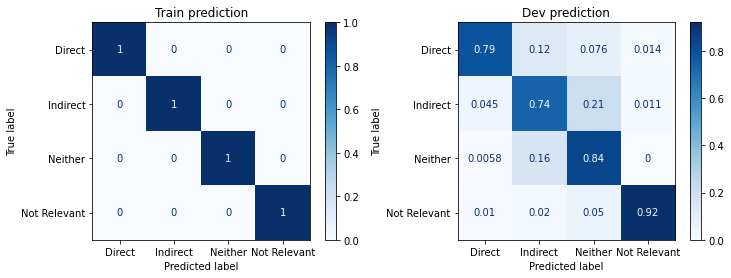

In [29]:
dir_step_list_best = [
    ('../results/sent_rel_bert-base-uncased/', 8000),
    ('../results/sent_rel_PubMedBERT/', 9999),
    ('../results/sent_rel_BioClinicalBERT/', 7000),
    ('../results/sent_rel_BlueBERT-Base/', 9999),
#     ('../results/sent_rel_BlueBERT-Large/', 7000),
#     ('../results/sent_sim_bert-base-uncased/', 7000),
#     ('../results/sent_sim2_bert-base-uncased/', 9999),
#     ('../results/sent_sim_PubMedBERT/', 9999),
#     ('../results/sent_sim2_PubMedBERT/', 8000),
]
plot_results_ensemble(dir_step_list_best, ensemble='probs')

- Sentence similarity models

Ensemble of following results
	(../results/sent_sim_bert-base-uncased/, step 9999)
	(../results/sent_sim2_bert-base-uncased/, step 9999)
	(../results/sent_sim_PubMedBERT/, step 9999)
	(../results/sent_sim2_PubMedBERT/, step 9999)
- Train set performance
    - Accuracy: 0.999784 (4632/4633)
    - Macro F1: 0.999816
- Dev set performance
    - Accuracy: 0.698492 (417/597)
    - Macro F1: 0.725983
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      100       32       13        0      145
Indirect        0     1248        1        0     1249 | Indirect       15      116       46        2      179
 Neither        0        0     1484        0     1484 |  Neither        6       50      115        2      173
Not Rele        0        0        0      810      810 | Not Rele        7        4        3       86      100
Pred cnt     1090     1248     1485      810     463

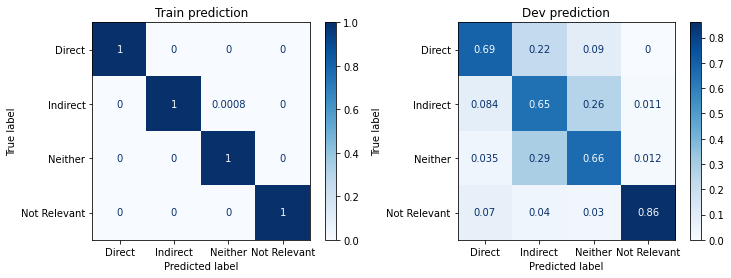

In [30]:
dir_step_list_best = [
#     ('../results/sent_rel_bert-base-uncased/', 8000),
#     ('../results/sent_rel_PubMedBERT/', 9999),
#     ('../results/sent_rel_BioClinicalBERT/', 7000),
#     ('../results/sent_rel_BlueBERT-Base/', 9999),
#     ('../results/sent_rel_BlueBERT-Large/', 7000),
    ('../results/sent_sim_bert-base-uncased/', 9999),
    ('../results/sent_sim2_bert-base-uncased/', 9999),
    ('../results/sent_sim_PubMedBERT/', 9999),
    ('../results/sent_sim2_PubMedBERT/', 9999),
]
plot_results_ensemble(dir_step_list_best, ensemble='probs')

- All models

Ensemble of following results
	(../results/sent_rel_PubMedBERT/, step 9999)
	(../results/sent_rel_BioClinicalBERT/, step 7000)
	(../results/sent_rel_BlueBERT-Base/, step 6000)
	(../results/sent_rel_BlueBERT-Large/, step 7000)
	(../results/sent_sim_bert-base-uncased/, step 7000)
	(../results/sent_sim2_PubMedBERT/, step 8000)
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.810720 (484/597)
    - Macro F1: 0.828412
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      113       25        6        1      145
Indirect        0     1249        0        0     1249 | Indirect       10      137       31        1      179
 Neither        0        0     1484        0     1484 |  Neither        1       30      142        0      173
Not Rele        0        0        0      810      810 | Not Rele  

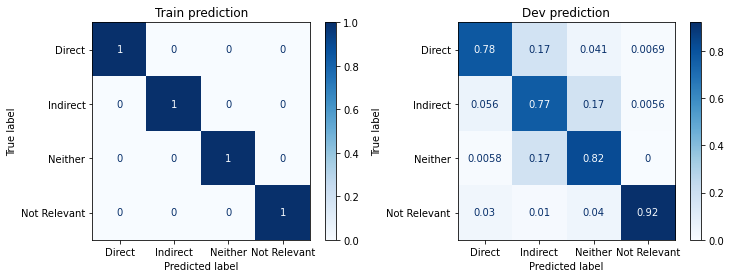

In [31]:
dir_step_list_best = [
#     ('../results/sent_rel_bert-base-uncased/', 8000),
    ('../results/sent_rel_PubMedBERT/', 9999),
    ('../results/sent_rel_BioClinicalBERT/', 7000),
    ('../results/sent_rel_BlueBERT-Base/', 6000),
    ('../results/sent_rel_BlueBERT-Large/', 7000),
    ('../results/sent_sim_bert-base-uncased/', 7000),
#     ('../results/sent_sim2_bert-base-uncased/', 9999),
#     ('../results/sent_sim_PubMedBERT/', 9999),
    ('../results/sent_sim2_PubMedBERT/', 8000),
]
plot_results_ensemble(dir_step_list_best, ensemble='probs')

### Overfitting check

Split the dev set into two and check the correlation between their macro f1 scores  
$\rightarrow$ There is a risk of overfitting

Check the ensembles of the sentence relation models
- If we fit the ensemble to the set 1 (`macro-f1_1 = 0.829125`), then `macro-f1_2 = 0.818834`  
- If we fit the ensemble to the set 2 (`macro-f1_2 = 0.831308`), then `macro-f1_1 = 0.813247`

                 devset 1 devset 2 devtotal
(0, 1, 1, 0, 2): 0.829125 0.818834 0.824643
(2, 2, 1, 1, 0): 0.813247 0.831308 0.822786


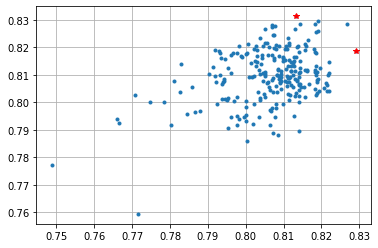

In [32]:
exp_list_sent_rel = ['sent_rel_bert-base-uncased',
                     'sent_rel_PubMedBERT',
                     'sent_rel_BioClinicalBERT',
                     'sent_rel_BlueBERT-Base',
                     'sent_rel_BlueBERT-Large']
logit_items_list_sent_rel = [len(exp_dev_logits_dict[exp_name]) for exp_name in exp_list_sent_rel]
dev_labels1, dev_labels2 = dev_labels[0::2], dev_labels[1::2]
macro_f1s_1, macro_f1s_2, = [], []
best_idx_list_1, best_f1_1_1, best_f1_1_2, best_f1_1 = (), 0.0, 0.0, 0.0
best_idx_list_2, best_f1_2_1, best_f1_2_2, best_f1_2 = (), 0.0, 0.0, 0.0

for idx_list in itertools.product(*[list(range(items)) for items in logit_items_list_sent_rel]):
    ensemble_dev_preds = ensemble_preds(idx_list, exp_list_sent_rel, "probs")
    dev_preds1, dev_preds2 = ensemble_dev_preds[0::2], ensemble_dev_preds[1::2]
    macro_f1_1 = sklearn.metrics.f1_score(y_true=dev_labels1, y_pred=dev_preds1, average="macro")
    macro_f1_2 = sklearn.metrics.f1_score(y_true=dev_labels2, y_pred=dev_preds2, average="macro")
    macro_f1s_1.append(macro_f1_1)
    macro_f1s_2.append(macro_f1_2)
    if macro_f1_1 > best_f1_1_1:
        macro_f1 = sklearn.metrics.f1_score(y_true=dev_labels, y_pred=ensemble_dev_preds, average="macro")
        best_idx_list_1, best_f1_1_1, best_f1_1_2, best_f1_1 = \
            idx_list, macro_f1_1, macro_f1_2, macro_f1
    if macro_f1_2 > best_f1_2_2:
        macro_f1 = sklearn.metrics.f1_score(y_true=dev_labels, y_pred=ensemble_dev_preds, average="macro")
        best_idx_list_2, best_f1_2_1, best_f1_2_2, best_f1_2 = \
            idx_list, macro_f1_1, macro_f1_2, macro_f1
        
print(' ' * 17 + 'devset 1 devset 2 devtotal')
print(f'{best_idx_list_1}: {best_f1_1_1:.6f} {best_f1_1_2:.6f} {best_f1_1:.6f}')
print(f'{best_idx_list_2}: {best_f1_2_1:.6f} {best_f1_2_2:.6f} {best_f1_2:.6f}')
plt.plot(macro_f1s_1[1:], macro_f1s_2[1:], '.')  # Plot without the zero prediction
plt.plot(best_f1_1_1, best_f1_1_2, 'r*')
plt.plot(best_f1_2_1, best_f1_2_2, 'r*')
plt.grid(True)

In [33]:
np.corrcoef(macro_f1s_1[1:], macro_f1s_2[1:])[0, 1]

0.3920241992205135

Check the ensembles of the sentence relation models
- If we fit the ensemble to the set 1 (`macro-f1_1 = 0.835789`), then `macro-f1_2 = 0.815570`  
- If we fit the ensemble to the set 2 (`macro-f1_2 = 0.835445`), then `macro-f1_1 = 0.813579`

                             devset 1 devset 2 devtotal
(1, 2, 1, 0, 1, 1, 1, 0, 0): 0.835789 0.815570 0.826140
(2, 2, 1, 1, 0, 0, 1, 1, 0): 0.813579 0.835445 0.825127


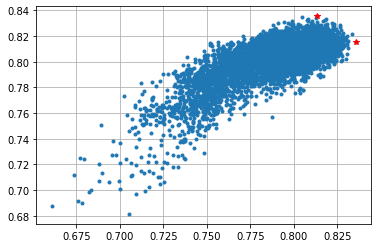

In [34]:
dev_labels1, dev_labels2 = dev_labels[0::2], dev_labels[1::2]
macro_f1s_1, macro_f1s_2, = [], []
best_idx_list_1, best_f1_1_1, best_f1_1_2, best_f1_1 = (), 0.0, 0.0, 0.0
best_idx_list_2, best_f1_2_1, best_f1_2_2, best_f1_2 = (), 0.0, 0.0, 0.0

for idx_list in itertools.product(*[list(range(items)) for items in logit_items_list]):
    ensemble_dev_preds = ensemble_preds(idx_list, ensemble="probs")
    dev_preds1, dev_preds2 = ensemble_dev_preds[0::2], ensemble_dev_preds[1::2]
    macro_f1_1 = sklearn.metrics.f1_score(y_true=dev_labels1, y_pred=dev_preds1, average="macro")
    macro_f1_2 = sklearn.metrics.f1_score(y_true=dev_labels2, y_pred=dev_preds2, average="macro")
    macro_f1s_1.append(macro_f1_1)
    macro_f1s_2.append(macro_f1_2)
    if macro_f1_1 > best_f1_1_1:
        macro_f1 = sklearn.metrics.f1_score(y_true=dev_labels, y_pred=ensemble_dev_preds, average="macro")
        best_idx_list_1, best_f1_1_1, best_f1_1_2, best_f1_1 = \
            idx_list, macro_f1_1, macro_f1_2, macro_f1
    if macro_f1_2 > best_f1_2_2:
        macro_f1 = sklearn.metrics.f1_score(y_true=dev_labels, y_pred=ensemble_dev_preds, average="macro")
        best_idx_list_2, best_f1_2_1, best_f1_2_2, best_f1_2 = \
            idx_list, macro_f1_1, macro_f1_2, macro_f1

print(' ' * 29 + 'devset 1 devset 2 devtotal')
print(f'{best_idx_list_1}: {best_f1_1_1:.6f} {best_f1_1_2:.6f} {best_f1_1:.6f}')
print(f'{best_idx_list_2}: {best_f1_2_1:.6f} {best_f1_2_2:.6f} {best_f1_2:.6f}')
plt.plot(macro_f1s_1[1:], macro_f1s_2[1:], '.')  # Plot without the zero prediction
plt.plot(best_f1_1_1, best_f1_1_2, 'r*')
plt.plot(best_f1_2_1, best_f1_2_2, 'r*')
plt.grid(True)

In [35]:
np.corrcoef(macro_f1s_1[1:], macro_f1s_2[1:])[0, 1]

0.7381615442244343